In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')

import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
#from torch.optim.lr_scheduler import StepLR

import time

In [23]:
# Parameters
params_dictionary = {
    'hidden size': 25,
    'hidden size 2': 10,
    'layers': 1,
    'learning rate': 0.001,
    'epochs': 100,
    'alpha' : 4
}

In [24]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

# Make the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 1070


In [25]:
# Upload the data frame into the notebook
data_frame = pd.read_csv('Data/data_cantilever_beam_independent_samples_32_40_100_cupy.csv')
kalman_results = pd.read_csv('Data/kalman_results_cantilever_beam_independent_samples_32_40_100_cupy.csv')

In [26]:
display(data_frame.head(5))

,y1,y2,y3,y4,y5,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0.068647,0.052983,-0.073552,0.071539,-0.016651,0.038528,0.003422,0.028885,0.032134,-0.028148,1.517228,0.015991,-1.693990,0.000329,3.748321
1,0.142693,0.056418,-0.063792,0.041492,-0.023979,0.035372,-0.007735,0.024107,-0.180693,-0.007200,2.437605,-0.011293,-4.296211,0.008552,1.134709
2,-0.033175,-0.020723,0.037679,0.011972,-0.048529,0.004014,-0.072067,0.014381,-0.335691,0.028210,2.635092,0.008202,-1.334215,-0.023549,-4.394074
3,-0.012888,0.035991,0.101281,0.016413,-0.082814,-0.016517,-0.063020,-0.012710,-0.416302,0.043005,1.586260,0.017632,-2.574984,-0.003426,11.686208
4,-0.090660,-0.056854,0.043681,-0.044437,0.090732,-0.027299,-0.027300,-0.008602,-0.298500,0.060498,0.042303,-0.050744,-5.359601,0.055580,6.055688


In [27]:
# Degrees of freedom
dof = 5

# Defining a batch size based on the data
seq_len = 100
batch_size = 32
num_batches = 40
num_seqs = int(data_frame.shape[0] / seq_len)
print(f'[DEBUG] number of sequences: {num_seqs}')

# Split the dataset into sequences
seq_data = np.array_split(data_frame,num_seqs,axis=0)
print(f'[DEBUG] data size: {len(seq_data)}')
kf_data = np.array_split(kalman_results,num_seqs,axis=0)
print(f'[DEBUG] Kalman data size: {len(kf_data)}')

# Randomly choose the validation sequences, and move them to the back of the dataset
num_val_seq = int(np.floor(num_seqs*0.2))
test_seq_ids = np.random.choice(num_seqs, num_val_seq, replace=False)

for i in range(num_val_seq):
    seq_data.append(seq_data.pop(test_seq_ids[i]))
    kf_data.append(kf_data.pop(test_seq_ids[i]))

# Combining all the sequences to form a single dataset
df = pd.DataFrame(np.concatenate(seq_data),columns=list(data_frame.columns))
kf = pd.DataFrame(np.concatenate(kf_data),columns=list(kalman_results.columns))

[DEBUG] number of sequences: 1280
[DEBUG] data size: 1280
[DEBUG] Kalman data size: 1280


In [28]:
# Get the size of the validation set
val_size = seq_len*num_val_seq

y = df.values.astype(float)
x_hat = kf.values.astype(float)

# Create train and test sets
train_set = y[:-val_size]
test_set = y[-val_size:]

kf_set = x_hat[-val_size:]

In [29]:
# Scaling the training and testing data 
scaler1 = MinMaxScaler(feature_range=(-1, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))

# Fitting a scaler for states and inputs seperately
train_norm_inputs = scaler1.fit_transform(train_set[:,:dof].reshape(-1,dof))
train_norm_states = scaler2.fit_transform(train_set[:,dof:].reshape(-1,2*dof))

train_norm = np.hstack((train_norm_inputs, train_norm_states))

test_norm_inputs = scaler1.transform(test_set[:,:dof].reshape(-1,dof))
test_norm_states = scaler2.transform(test_set[:,dof:].reshape(-1,2*dof))

test_norm = np.hstack((test_norm_inputs, test_norm_states))

In [30]:
# Convert train set into a torch tensor
train_set_norm = torch.FloatTensor(train_norm).view(-1,df.shape[1])
test_set_norm = torch.FloatTensor(test_norm).view(-1,df.shape[1])
kf_results = torch.FloatTensor(kf_set).view(-1,kf.shape[1])

# Transfer tensors to GPU, if available
train_set_norm = train_set_norm.to(device)
test_set_norm = test_set_norm.to(device)

In [31]:
# A function to generate the input data for the LSTM
def input_data(seqs,bat_count):
    batch_len = batch_size*seq_len

    inp_data = []
    for batch in range(bat_count):
        cur_batch = seqs[batch*batch_len:batch*batch_len+batch_len,:]

        #print(f'[DEBUG] batch {batch}/{bat_count-1}')
        #print(f'[DEBUG] initial batch shape: {cur_batch.size()}')
        
        batch_seq_features = []
        batch_seq_labels = []
        for seq in range(batch_size):
            #print(f'[DEBUG] sequence {seq}/{batch_size-1}')
            feature = torch.unsqueeze(cur_batch[seq*seq_len:seq*seq_len+seq_len,:dof],dim=0)
            label = torch.unsqueeze(cur_batch[seq*seq_len:seq*seq_len+seq_len,dof:],dim=0)

            #print(f'[DEBUG] feature shape: {feature.size()}, label shape: {label.size()}')

            batch_seq_features.append(feature)
            batch_seq_labels.append(label)

        features = torch.cat(batch_seq_features,dim=0) # Batch first
        labels = torch.cat(batch_seq_labels,dim=0)

        #print(f'[DEBUG] batched features shape: {features.size()}, batched labels shape: {labels.size()}')

        inp_data.append((features,labels))
        
    return inp_data

In [32]:
# Create training and validation data sets
num_val_bat = int(np.floor(num_batches*0.2))
#print(f'Generating training data')
train_data = input_data(train_set_norm,num_batches-num_val_bat) # List of tuples (batched features, batched labels)
#print(f'Generating validation data')
val_data = input_data(test_set_norm,num_val_bat)

In [33]:
# Defining the LSTM model with two hidden layers
class LSTMmodel(nn.Module):
    
    def __init__(self,input_size,hidden_size_1,out_size):
        
        super().__init__()
        
        self.hidden_size_1 = hidden_size_1
        
        #self.hidden_size_2 = hidden_size_2
        
        self.input_size = input_size
        
        # Add dropout here if needed
        self.lstm_1 = nn.LSTM(input_size,hidden_size_1,num_layers=params_dictionary['layers'],batch_first=True)
        
        #self.lstm_2 = nn.LSTM(hidden_size_1,hidden_size_2)
        
        self.linear = nn.Linear(hidden_size_1,out_size)
        
        self.hidden_1 = (torch.zeros(params_dictionary['layers'],batch_size,hidden_size_1), torch.zeros(params_dictionary['layers'],batch_size,hidden_size_1))
        
        #self.hidden_2 = (torch.zeros(1,1,hidden_size_2), torch.zeros(1,1,hidden_size_2))
        
    def forward(self,seq):
        
        lstm_out_1 , self.hidden_1 = self.lstm_1(seq,self.hidden_1)
        
        #lstm_out_2 , self.hidden_2 = self.lstm_2(lstm_out_1,self.hidden_2)
        
        pred = self.linear(lstm_out_1)
        
        return pred

In [34]:
# Creating a model instance, loss function and the optimizer
model = LSTMmodel(input_size=dof,hidden_size_1=params_dictionary['hidden size'],out_size=2*dof)
model_2 = LSTMmodel(input_size=dof,hidden_size_1=25,out_size=2*dof)
model_3 = LSTMmodel(input_size=dof,hidden_size_1=25,out_size=2*dof)

# Transfer the model to a CUDA enabled GPU, if available
model = model.to(device)

checkpoint = torch.load('Models/LSTM-5DoF-SMD-06232023-checkpoint.pt')

model_2 = model_2.to(device)
model_2.load_state_dict(checkpoint['model_state_dict'])

model_3 = model_3.to(device)
model_3.load_state_dict(checkpoint['model_state_dict'])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params_dictionary['learning rate'])
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=params_dictionary['learning rate'])
optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])

# LR scheduler: reduce lr on plateau of 5 epochs with factor of 0.25
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)
#scheduler = StepLR(optimizer, step_size=40, gamma=0.95)

In [35]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'learning rate: ', {params_dictionary['learning rate']})
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

learning rate:  {0.001}
   500
  2500
   100
   100
   250
    10
______
  3460


In [36]:
# Set the number of epochs
epochs = params_dictionary['epochs']

# Initialize validation data
#true_values = test_set_norm[:,dof:]

# Define arrays to store training and validation losses per epoch
training_losses = np.empty(epochs)
training_losses_2 = np.empty(epochs)
validation_losses = np.empty(epochs)
validation_losses_2 = np.empty(epochs)

for epoch in range(1,epochs+1):
    
    # Running each batch separately
    model.train()
    model_2.train()
    
    # Each tuple represents one batch
    for features,labels in train_data:
            
        # set the optimization gradient to zero
        optimizer.zero_grad()
        optimizer_2.zero_grad()
            
        # initialize the hidden states
        model.hidden_1 = (torch.zeros(params_dictionary['layers'],batch_size,model.hidden_size_1).to(device),
                        torch.zeros(params_dictionary['layers'],batch_size,model.hidden_size_1).to(device))
        
        model_2.hidden_1 = (torch.zeros(params_dictionary['layers'],batch_size,model_2.hidden_size_1).to(device),
                        torch.zeros(params_dictionary['layers'],batch_size,model_2.hidden_size_1).to(device))
            
        # Make predictions on the current sequence
        y_pred = model(features)
        y_pred_2 = model_2(features)
        
        # Only want last prediction for many-to-one evaluation
        #last_pred = y_pred[-1]
            
        # Compute the loss
        #last_label = label[-1]
      
        loss = criterion(y_pred,labels)
        loss_2 = criterion(y_pred_2,labels)
            
        # Perform back propogation and gradient descent
        loss.backward()
        loss_2.backward()
        optimizer.step()
        optimizer_2.step()

    # Validate every epoch
    num_val_batch = num_val_seq/seq_len

    batch_losses = []
    batch_losses_2 = []
    for features,labels in val_data:
        # Set the model to evaluation mode
        model.eval()
        model_2.eval()
        #preds.append(test_set_norm[batch_size*i,dof:].reshape(-1,2*dof))
    
        # Inform PyTorch that I am no longer interested in the gradients
        with torch.no_grad():
            pred = model(features)
            pred_2 = model_2(features)
    
        batch_losses.append(criterion(pred,labels).cpu())
        batch_losses_2.append(criterion(pred_2,labels).cpu())
    
    validation_loss = np.average(batch_losses)
    validation_loss_2 = np.average(batch_losses_2)

    training_losses[epoch-1] = loss.item()
    training_losses_2[epoch-1] = loss_2.item()
    validation_losses[epoch-1] = validation_loss
    validation_losses_2[epoch-1] = validation_loss_2

    #scheduler.step(validation_loss)
    #scheduler.step()
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch} Training loss 1: {loss.item():10.8f}, Training loss 2: {loss_2.item():10.8f}, Validation loss 1: {validation_loss:10.8f}, Validation loss 2: {validation_loss_2:10.8f}')

c:\Users\Aki\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch: 5 Training loss 1: 0.02004856, Training loss 2: 0.01089002, Validation loss 1: 0.02027456, Validation loss 2: 0.01082574
Epoch: 10 Training loss 1: 0.01215798, Training loss 2: 0.01000436, Validation loss 1: 0.01265138, Validation loss 2: 0.01029345
Epoch: 15 Training loss 1: 0.01039272, Training loss 2: 0.00975274, Validation loss 1: 0.01101177, Validation loss 2: 0.01024901
Epoch: 20 Training loss 1: 0.01000355, Training loss 2: 0.00965356, Validation loss 1: 0.01081435, Validation loss 2: 0.01028035
Epoch: 25 Training loss 1: 0.00982863, Training loss 2: 0.00960224, Validation loss 1: 0.01079295, Validation loss 2: 0.01030986
Epoch: 30 Training loss 1: 0.00967408, Training loss 2: 0.00957047, Validation loss 1: 0.01072411, Validation loss 2: 0.01032917
Epoch: 35 Training loss 1: 0.00959831, Training loss 2: 0.00954837, Validation loss 1: 0.01070955, Validation loss 2: 0.01034261
Epoch: 40 Training loss 1: 0.00955633, Training loss 2: 0.00953177, Validation loss 1: 0.01076529,

C:\Users\Aki\AppData\Local\Temp\ipykernel_87492\2977955933.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


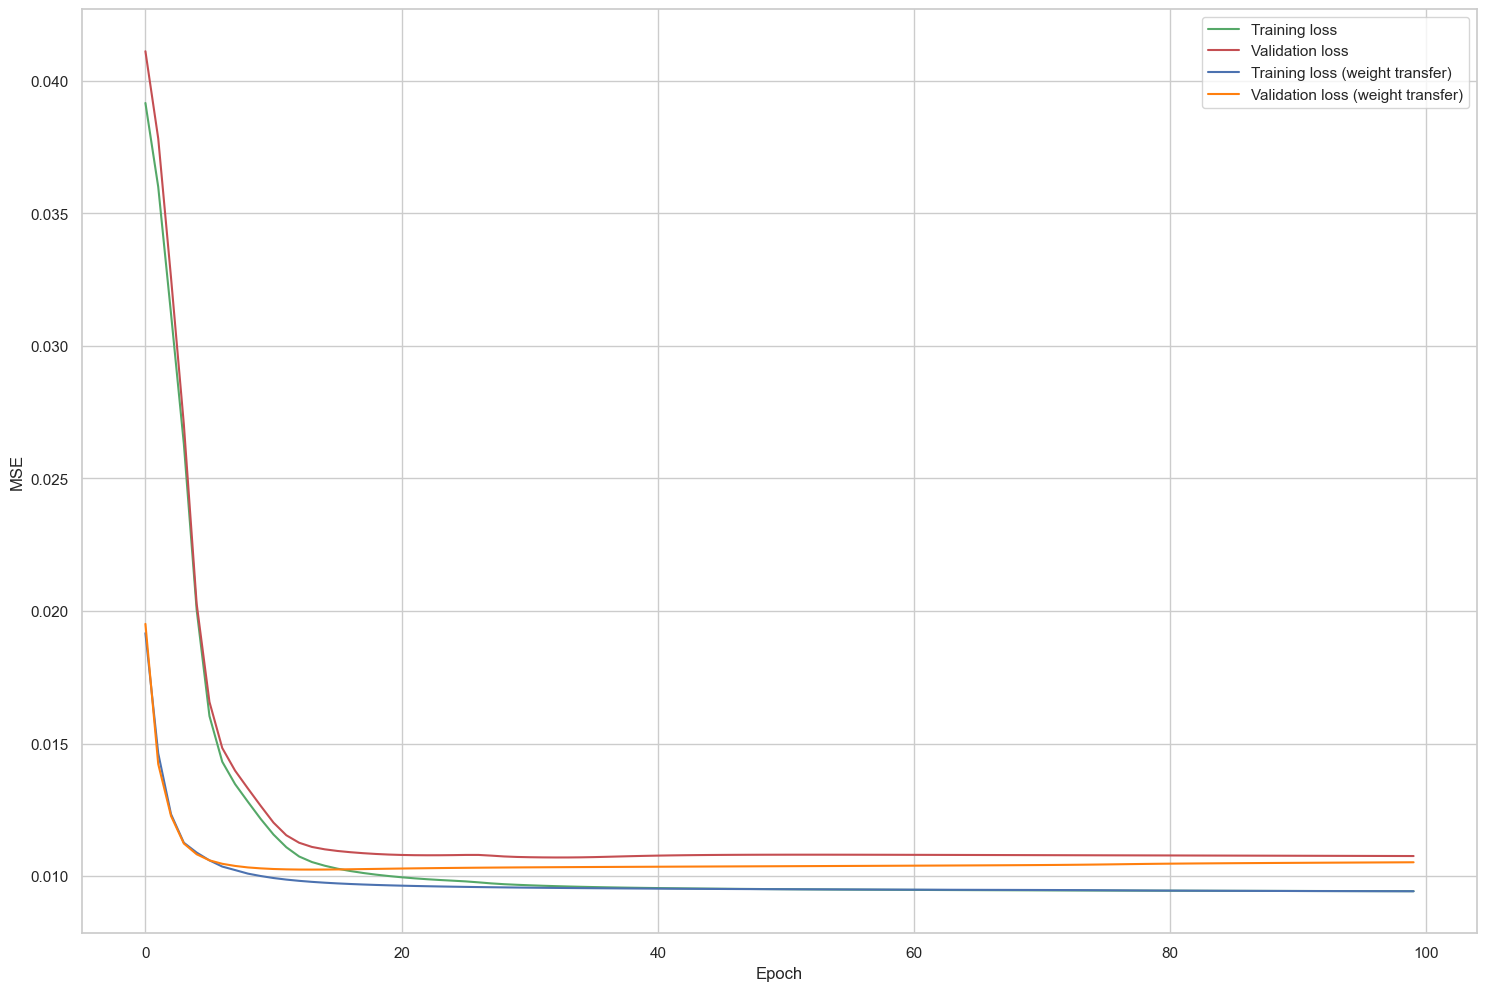

In [37]:
fig = plt.figure(1)
plt.plot(training_losses,'g',label='Training loss')
plt.plot(validation_losses,'r',label='Validation loss')

plt.plot(training_losses_2,'b',label='Training loss (weight transfer)')
plt.plot(validation_losses_2,'tab:orange',label='Validation loss (weight transfer)')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
fig.show()

In [38]:
# Testing: feed one testing batch at a time
num_test_batches = int(len(test_set_norm)/batch_size)

preds = []
preds_2 = []
preds_3 = []
disp_preds = []
disp_preds_2 = []
disp_preds_3 = []
num_val_batch = num_val_seq/seq_len

test_batch_losses = []
test_batch_losses_2 = []
test_batch_losses_3 = []

t0 = time.time()
for features,labels in val_data:
    # Set the model to evaluation mode
    model.eval()
    model_2.eval()
    model_3.eval()
    model_3.hidden_1 = (torch.zeros(params_dictionary['layers'],batch_size,model_3.hidden_size_1).to(device), torch.zeros(params_dictionary['layers'],batch_size,model_3.hidden_size_1).to(device))
    
    # Inform PyTorch that I am no longer interested in the gradients
    with torch.no_grad():
        pred = model(features)
        pred_2 = model_2(features)
        pred_3 = model_3(features)
    
    preds.append(pred)
    preds_2.append(pred_2)
    preds_3.append(pred_3)
    disp_preds.append(torch.squeeze(pred[0],dim=0).cpu())
    disp_preds_2.append(torch.squeeze(pred_2[0],dim=0).cpu())
    disp_preds_3.append(torch.squeeze(pred_3[0],dim=0).cpu())
    test_batch_losses.append(criterion(pred,labels))
    test_batch_losses_2.append(criterion(pred_2,labels))
    test_batch_losses_3.append(criterion(pred_3,labels))

t1 = time.time()

print(f'Time required to evaluate test set: {t1-t0} seconds')

Time required to evaluate test set: 0.022002696990966797 seconds


In [39]:
predictions = scaler2.inverse_transform(np.array([pred.numpy() for pred in disp_preds]).reshape(-1,2*dof))
predictions_2 = scaler2.inverse_transform(np.array([pred.numpy() for pred in disp_preds_2]).reshape(-1,2*dof))
predictions_3 = scaler2.inverse_transform(np.array([pred.numpy() for pred in disp_preds_3]).reshape(-1,2*dof))
true_values = np.array(test_set[:,dof:])

In [40]:
rnn_mse = 0
rnn_mse_2 = 0
rnn_mse_3 = 0
kf_mse = 0
for i in range(2*dof):
    rnn_mse = rnn_mse + np.var(true_values[:seq_len,i]-predictions[:seq_len,i])
    rnn_mse_2 = rnn_mse_2 + np.var(true_values[:seq_len,i]-predictions_2[:seq_len,i])
    rnn_mse_3 = rnn_mse_3 + np.var(true_values[:seq_len,i]-predictions_3[:seq_len,i])
    kf_mse = kf_mse + np.var(true_values[:seq_len,i]-kf_set[:seq_len,i])

print(f"RNN MSE: {rnn_mse}, RNN RMSE:{np.sqrt(rnn_mse)}")
print(f"RNN MSE (weight transfer): {rnn_mse_2}, RNN RMSE (weight transfer):{np.sqrt(rnn_mse_2)}")
print(f"RNN MSE (weight transfer, untrained): {rnn_mse_3}, RNN RMSE (weight transfer, untrained):{np.sqrt(rnn_mse_3)}")
print(f"Kalman filter MSE: {kf_mse}, Kalman filter: RMSE: {np.sqrt(kf_mse)}")
print(f"Percentage: {100*(rnn_mse/kf_mse)}")
print(f"Percentage (weight transfer): {100*(rnn_mse_2/kf_mse)}")
print(f"Percentage (weight transfer, untrained): {100*(rnn_mse_3/kf_mse)}")

RNN MSE: 495.59043324319634, RNN RMSE:22.261860507226174
RNN MSE (weight transfer): 471.7181625923454, RNN RMSE (weight transfer):21.719073704749597
RNN MSE (weight transfer, untrained): 7517.668296986055, RNN RMSE (weight transfer, untrained):86.70448833241596
Kalman filter MSE: 514.6150462731325, Kalman filter: RMSE: 22.685128306296452
Percentage: 96.30313704045123
Percentage (weight transfer): 91.66427721236515
Percentage (weight transfer, untrained): 1460.8333649451913


Text(0, 0.5, 'Mean squared error')

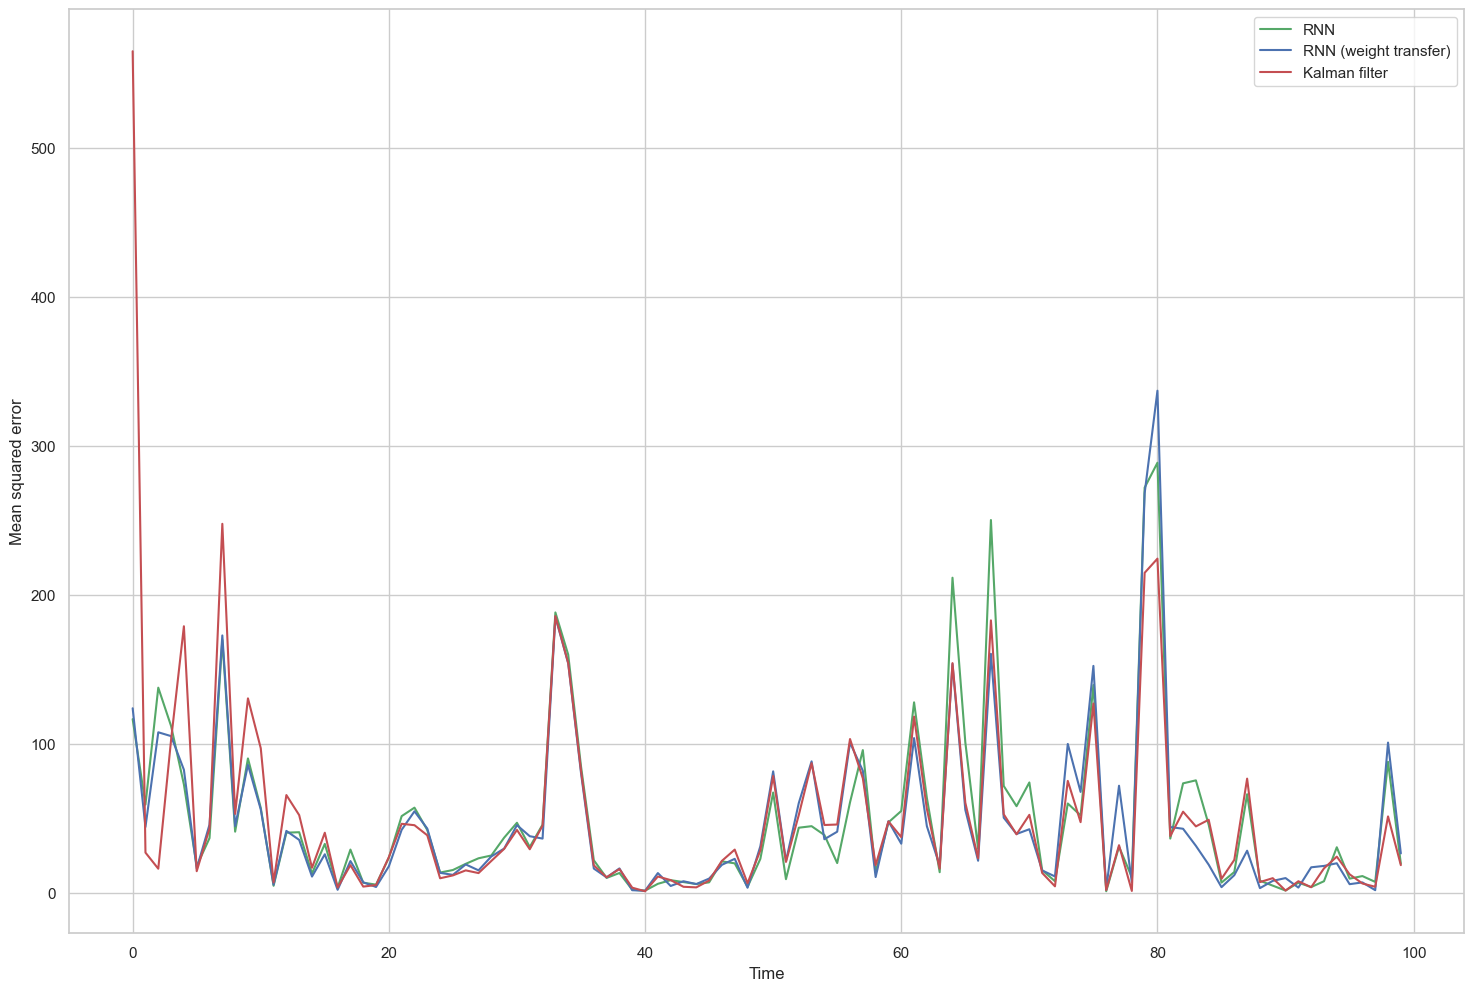

In [41]:
fig = plt.figure()

'''
for i in range(0,2*dof):
    plt.subplot(2*dof, 2, 2*i+1)
    plt.plot(predictions[:seq_len,i],'g',label='RNN')
    plt.plot(predictions_2[:seq_len,i],'b',label='RNN (weight transfer)')
    plt.plot(predictions_3[:seq_len,i],'tab:orange',label='RNN (weight transfer, untrained)')
    plt.plot(true_values[:seq_len,i],'tab:purple',label='True Value')
    plt.plot(kf_results[:seq_len,i],'r',label='KF')
    plt.legend(loc="upper right")
    plt.xlabel('Time')
    plt.ylabel(f"x{i}")

    plt.subplot(2*dof, 2, 2*i+2)
    plt.plot(abs(true_values[:seq_len,i] - predictions[:seq_len,i]),'g',label='RNN')
    plt.plot(abs(true_values[:seq_len,i] - predictions_2[:seq_len,i]),'b',label='RNN (weight transfer)')
    plt.plot(abs(true_values[:seq_len,i] - predictions_3[:seq_len,i]),'tab:orange',label='RNN (weight transfer, untrained)')
    plt.plot(abs(true_values[:seq_len,i] - kf_results[:seq_len,i].numpy()),'r',label='KF')
    plt.legend(loc="upper right")
    plt.xlabel('Time')
    plt.ylabel(f"x{i} error");
'''

rnn_mse_list = []
rnn_mse_list_2 = []
kf_mse_list = []

for i in range(seq_len):
    rnn_mse_list.append(mean_squared_error(true_values[i],predictions[i]))
    rnn_mse_list_2.append(mean_squared_error(true_values[i],predictions_2[i]))
    kf_mse_list.append(mean_squared_error(true_values[i],kf_results[i].numpy()))

plt.plot(rnn_mse_list,'g',label='RNN')
plt.plot(rnn_mse_list_2,'b',label='RNN (weight transfer)')
plt.plot(kf_mse_list,'r',label='Kalman filter')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.ylabel(f"Mean squared error")

In [42]:
#torch.save(model.state_dict(), 'Models/LSTM-cantilever-beam-03032023.pt')
#torch.save(model_2.state_dict(), 'Models/LSTM-cantilever-beam-wt-03032023.pt')

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'Models/LSTM-cantilever-beam-06232023-checkpoint.pt')

torch.save({
            'epoch': epoch,
            'model_state_dict': model_2.state_dict(),
            'optimizer_state_dict': optimizer_2.state_dict(),
            'loss': loss_2
            }, 'Models/LSTM-cantilever-beam-wt-06232023-checkpoint.pt')